
Performing 3-Fold Cross-Validation...
Cross-Validation Scores: [0.6333333333333333, 0.6896551724137931, 0.5517241379310345]
Mean Cross-Validation Accuracy: 0.625

Test Set Metrics:
Accuracy: 0.773
Sensitivity: 0.4
Specificity: 0.8823529411764706
Precision: 0.5
Miss Rate: 0.6
False Discovery Rate: 0.5
False Omission Rate: 0.16666666666666666
TP: 2, FP: 2, TN: 15, FN: 3

Top 20 Features (Mutations):
                                                Feature  Importance
796   PIK3CA_GRCh37_3:178916876-178916876_Missense-M...    0.036671
1093  ARL4D_GRCh37_17:41477713-41477713_3'UTR_DEL_C-C--    0.024730
318   KRAS_GRCh37_12:25398285-25398285_Missense-Muta...    0.023255
565   CNBD1_GRCh37_8:88365898-88365898_Missense-Muta...    0.023055
544   SSPO_GRCh37_7:149475868-149475868_Splice-Site_...    0.022239
251   PCOLCE2_GRCh37_3:142567080-142567080_Missense-...    0.021685
568   MTUS2_GRCh37_13:29933476-29933476_Missense-Mut...    0.020203
656   TP53_GRCh37_17:7578406-7578406_Missense-Mutati..

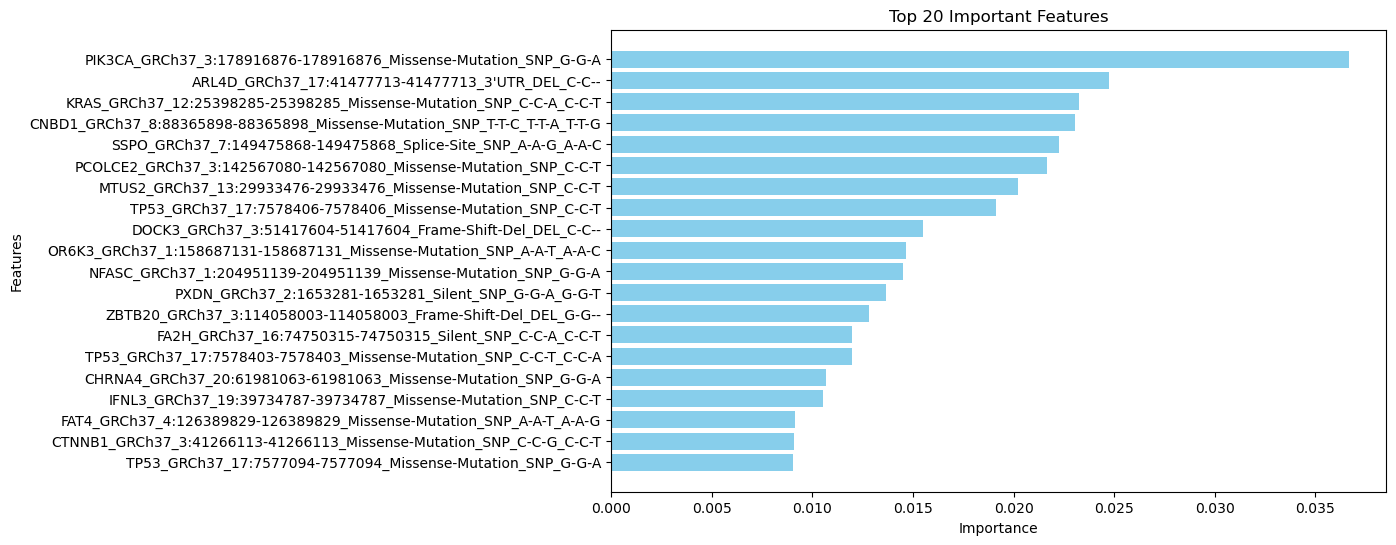

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt

# Step 1: Load the dataset
filename = '/Users/arjun/Desktop/ARJUN/FALL-2024/DATA_MINING/mutations.xlsx'
cancerData = pd.read_excel(filename)

# Step 2: Create target labels (C for Cancer, NC for Non-Cancer)
cancerData['Label'] = cancerData['Unnamed: 0'].apply(lambda x: 'C' if x.startswith('C') else 'NC')

# Step 3: Drop the 'Unnamed: 0' column 
cancerData = cancerData.drop(columns=['Unnamed: 0'])

# Step 4: Separate features (mutations) and target labels
X = cancerData.drop(columns=['Label'])  # Features (mutations)
y = cancerData['Label']  # Target labels (C/NC)

# Step 5: Splitting the dataset into training and testing sets
# 80% of the data for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Initialize the Random Forest model
rf = RandomForestClassifier(
    n_estimators=500,         # Number of trees in the forest
    max_depth=250,            # Allow trees to grow depth of 250
    max_features='sqrt',      # Use sqrt(number of features) for splits
    oob_score=True,           # Enable out-of-bag evaluation
    random_state=42           
)

# Step 7: 3-fold cross-validation during training
kf = KFold(n_splits=3, shuffle=True, random_state=42)
cv_scores = []

print("\nPerforming 3-Fold Cross-Validation...")

for train_index, val_index in kf.split(X_train):
    # Split the training data into training and validation sets
    X_cv_train, X_cv_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_cv_train, y_cv_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Train the model on the training fold
    rf.fit(X_cv_train, y_cv_train)
    
    # Evaluate on the validation fold and store accuracy
    score = rf.score(X_cv_val, y_cv_val)
    cv_scores.append(score)

# Display cross-validation results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores):.3f}")

# Step 8: Train the final model on the entire training set
rf.fit(X_train, y_train)

# Step 9: Evaluate the model on the test set
y_test_pred = rf.predict(X_test)

# Step 10: function to calculate the confusion matrix manually
def manual_confusion_matrix(true_labels, predicted_labels):
    # Get unique class labels
    classes = sorted(set(true_labels))
    # Initialize a dictionary to count occurrences
    matrix = {label: {label_: 0 for label_ in classes} for label in classes}
    
    # Count true vs. predicted class occurrences
    for true, pred in zip(true_labels, predicted_labels):
        matrix[true][pred] += 1

    # Print the confusion matrix
    #print("\nConfusion Matrix:")
    #print("         ", "  ".join(classes))
    for label, row in matrix.items():
        row_str = "  ".join(f"{count:5}" for count in row.values())
        #print(f"{label:<8}{row_str}")
    return matrix

# Calculate the confusion matrix for the test set
test_conf_matrix = manual_confusion_matrix(y_test, y_test_pred)

# Step 11: function to calculate performance metrics manually
def calculate_metrics(conf_matrix):
    # Extract values from the confusion matrix
    TP = conf_matrix['C']['C']  # True Positives: Predicted C, Actual C
    FP = conf_matrix['NC']['C']  # False Positives: Predicted C, Actual NC
    TN = conf_matrix['NC']['NC']  # True Negatives: Predicted NC, Actual NC
    FN = conf_matrix['C']['NC']  # False Negatives: Predicted NC, Actual C

    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0  # Recall
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    miss_rate = FN / (TP + FN) if (TP + FN) > 0 else 0
    false_discovery_rate = FP / (TP + FP) if (TP + FP) > 0 else 0
    false_omission_rate = FN / (FN + TN) if (FN + TN) > 0 else 0

    # Display the results in the desired format
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")
    print(f"Precision: {precision}")
    print(f"Miss Rate: {miss_rate}")
    print(f"False Discovery Rate: {false_discovery_rate}")
    print(f"False Omission Rate: {false_omission_rate}")
    print(f"TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}")

# Step 12: Calculate and display metrics for the test set
print("\nTest Set Metrics:")
calculate_metrics(test_conf_matrix)

# Step 13: Analyze feature importance
importances = rf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the top 20 most important mutations
top_features = feature_importance_df.head(20)
print("\nTop 20 Features (Mutations):")
print(top_features)

# Plot the top 20 most important features
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 20 Important Features')
plt.gca().invert_yaxis()  # Flip the y-axis so the most important feature is at the top
plt.show()

# Display the most significant mutations (importance above 0.01)
threshold = 0.01
selected_features = feature_importance_df[feature_importance_df['Importance'] > threshold]['Feature']


# **Project Discussion**

## **1. Research Objectives**
- Classify samples as cancerous (`C`) or non-cancerous (`NC`) using genetic mutation data.
- Identify significant mutations that differentiate cancerous samples for further research.

## **2. Key Results**
- **Test Set Metrics**:
  - Accuracy: **77.3%**
  - Sensitivity (Recall): **40%**
  - Specificity: **88.2%**
  - Precision: **50%**
  - Confusion Matrix:
    ```
              C   NC
       C      2    3
       NC     2   15
    ```
- **Cross-Validation Accuracy**: **62.5% (mean of 3 folds)**.
- **Top Mutations**:
  - **PIK3CA**: 0.0367 (most important).
  - Cancers with a high prevalence of activating PIK3CA mutations include breast (>30%), endometrial (>30%), bladder (>20%), colorectal carcinoma (>17%), and head and neck squamous cell carcinoma (>15%) 
  - **ARL4D**, **KRAS**, **TP53**, and others were significant.

## **3. Summary of Methods**
- **Data Preparation**:
  - Extracted `C/NC` labels from sample identifiers.
  - Split dataset into 80% training and 20% testing.
- **Model Training**:
  - Random Forest with 500 trees, deep structure, and `sqrt(n)` feature splits.
  - Performed 3-fold cross-validation for generalization.
- **Feature Importance**:
  - Ranked mutations based on their contribution to the model.
  - Selected key mutations for further analysis.

## **4. Evidence Supporting Results**
- **Test Metrics**:
    - Accuracy: 0.773, Sensitivity: 0.4, Specificity: 0.882 Precision: 0.5, False Discovery Rate: 0.5

- **Top Mutations**:
    - PIK3CA: 0.0367, ARL4D: 0.0247, KRAS: 0.0233, TP53: 0.0191

## **5. Discussion**
- **Insights**:
- Mutations like **PIK3CA**, **KRAS**, and **ARL4D**  are important genes linked to cancer.
- High specificity (88.2%) ensures reliability in identifying non-cancer cases.